In [47]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import json
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
dataDir='/home/gmayank43/cs230/datasets/'

### Adding some helper functions

In [46]:
def getCocoFromAnnotations(annFile):
        coco=COCO(annFile)
        return coco

def showImage(imgId):
    # load and display image
    # I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
    # use url to load image
    # print(img)
    I = io.imread(img['coco_url'])
    plt.axis('off')
    plt.imshow(I)
    plt.show()
    
def writeToFile(outdoorImageIds, dataType):
    filename = f'{dataType}_outdoor'
    print(f'\n Writing OutdoorImageIds to file {filename}')
    file1 = open(f'{dataType}_outdoor', 'w')
    file1.writelines(json.dumps(outdoorImageIds))

### Outdoor Dataset Generator can be used to get Outdoor Image Ids

In [43]:
class OutdoorDatasetGenerator:
    def __init__(self, coco):
        self.coco = coco
    
    def getCocoCategories(self):
        cats = self.coco.loadCats(self.coco.getCatIds())
        nms=[cat['name'] for cat in cats]
        print(f'There are {len(cats)} coco categories')
        return cats

    def getSuperCategories(self):
        cats = self.getCocoCategories()
        supercats = set([cat['supercategory'] for cat in cats])
        print(f'There are {len(supercats)} coco supercategories')
        # print('COCO supercategories: \n{}'.format(' '.join(nms)))
        return supercats

    def getOutdoorCategories(self):
        cats = self.getCocoCategories()
        outdoorCats = []
        for category in cats:
            if category['supercategory'] == 'outdoor' or category['supercategory'] == 'vehicle':
                outdoorCats.append(category['name'])
        print('Outdoor Categories are', outdoorCats)
        return outdoorCats

    def getOutdoorImageIds(self):
        outdoorCats = self.getOutdoorCategories()
        outdoorImageIds = []
        for cat in outdoorCats:
            catId = self.coco.getCatIds(catNms=[cat])[0];
            images = self.coco.getImgIds(catIds=catId)
            outdoorImageIds.extend(images)
        outdoorImageIds = list(set(outdoorImageIds))
        print(f'Total outdoor images are {len(outdoorImageIds)}')
        return outdoorImageIds
    
    def getImage(self, imgId):
        return self.coco.loadImgs(imgId)[0]

In [48]:
def GetOutdoorImages(dataType):
    print(f'Generating outdoor image dataset for {dataType}\n')
    print('Initialising COCO object for Instances data')
    instanceFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)
    instanceDataCoco = getCocoFromAnnotations(instanceFile)
    generator = OutdoorDatasetGenerator(instanceDataCoco)
    imageIds =  generator.getOutdoorImageIds()
    images = [generator.getImage(id) for id in outdoorImageIds]
    # print(len(images))
    return images

In [49]:
dataType='train2014'
outdoorImages = GetOutdoorImages(dataType)
writeToFile(outdoorImages, dataType)

Generating outdoor image dataset for train2014

Initialising COCO object for Instances data
loading annotations into memory...
Done (t=9.98s)
creating index...
index created!
There are 80 coco categories
Outdoor Categories are ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench']
Total outdoor images are 23686


### Captions Viewer can be used to get the captions given an image

In [50]:
class CaptionsViewer:
    def __init__(self, coco):
        self.coco = coco
        
    def showCaptions(self, img):
        annIds = self.coco.getAnnIds(imgIds=img['id']);
        anns = self.coco.loadAnns(annIds)
        self.coco.showAnns(anns)
        showImage(img)

Generating outdoor image dataset for train2014

Initialising COCO object for Instances data
loading annotations into memory...
Done (t=10.14s)
creating index...
index created!
There are 80 coco categories
Outdoor Categories are ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench']
Total outdoor images are 23686

Getting random outdoor image

Captions for Image: {'license': 1, 'file_name': 'COCO_train2014_000000074523.jpg', 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000074523.jpg', 'height': 640, 'width': 480, 'date_captured': '2013-11-16 20:52:56', 'flickr_url': 'http://farm6.staticflickr.com/5325/9422576685_099d322a81_z.jpg', 'id': 74523} are

A bus traveling down a street under a traffic signal.
A bus pulling up to a sidewalk where there are people standing.
People standing on a sidewalk as a bus stops at a bus stop.
A bus at a bus stop on a dreary day.
A bus ne

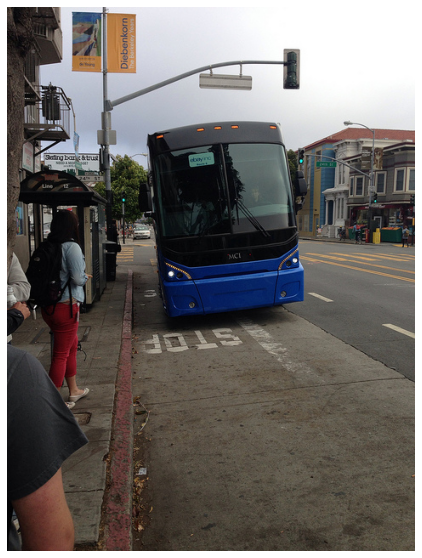

In [51]:
dataType='train2014'
outdoorImages = GetOutdoorImages(dataType)

print('\nGetting random outdoor image')
img = outdoorImages[np.random.randint(0,len(outdoorImages))]

print(f'\nCaptions for Image: {img} are\n')
captionsViewer = CaptionsViewer(captionsDataCoco)
captionsViewer.showCaptions(img)